In [1]:
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit import transpile
from qiskit.algorithms.optimizers import SLSQP, COBYLA
from qiskit.circuit.library import TwoLocal
import pylab
from qiskit.primitives import Estimator as Simulated_Estimator

# IBM quantum channel
QiskitRuntimeService.save_account(channel="ibm_quantum", token="75957d48e7acd59dee864e3c92f75b7b6befafd37e6f43b703f40fbfeed1cdb2406e6810336a13ad1d393009cd1f249cb3ebb222510676d94740aa1b85ee95a6", overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
print(service.backends())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibmq_belem')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>]


{   'aux_operators_evaluated': None,
    'cost_function_evals': 40,
    'eigenvalue': -1.264407135933392,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001931A6DF8E0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -4.707228823943394,
                              ParameterVectorElement(θ[5]): 6.151884926241717,
                              ParameterVectorElement(θ[2]): -1.36607529994086,
                              ParameterVectorElement(θ[3]): 7.790601770827874,
                              ParameterVectorElement(θ[4]): -2.1909033791361394,
                              ParameterVectorElement(θ[7]): 5.886166748674682,
                              ParameterVectorElement(θ[6]): -2.05984433025089,
                              ParameterVectorElement(θ[1]): 0.5918603962113296},
    'optimal_point': array([-4.70722882,  0.5918604 , -1.3660753 ,  7.79060177, -2.19090338,
        6.15188493, -2.05984433,  5.88616675]),
    'optima

Text(0.5, 1.0, 'Convergence using simulated estimator')

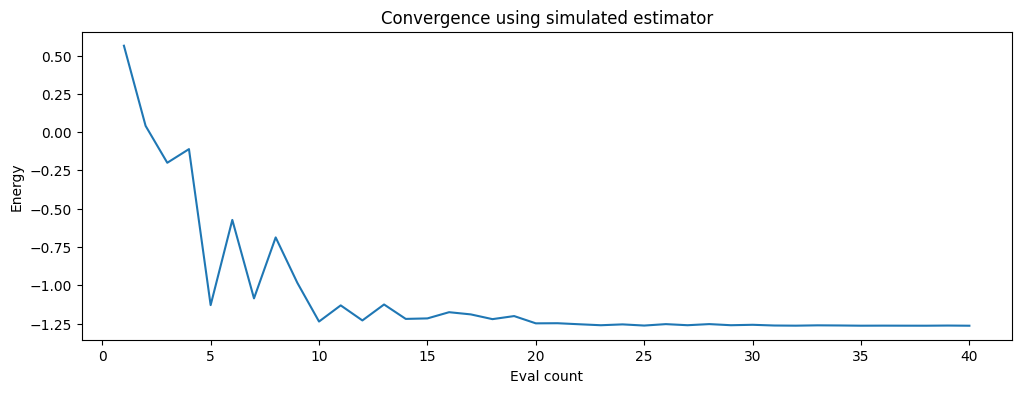

In [2]:
# define ansatz and optimizer
num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
# optimizer = SLSQP(maxiter=5)
optimizer = COBYLA(maxiter=40)

# define initial point
init_pt = [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]

# hamiltonian/operator --> use SparsePauliOp or Operator
from qiskit.quantum_info import SparsePauliOp

# hamiltonian = SparsePauliOp.from_list(
#     [
#         ("II", -1.052373245772859),
#         ("IZ", 0.39793742484318045),
#         ("ZI", -0.39793742484318045),
#         ("ZZ", -0.01128010425623538),
#         ("XX", 0.18093119978423156),
#     ]
# )

# define operator, here we're only going to run it with one specific (ω₁, ω₂, A) point
H_op = lambda omega_1, omega_2, A: SparsePauliOp.from_list([
    ("IZ", omega_1),
    ("ZI", omega_2),
    ("XX", A/2),
    ("YY", A/2),
])


counts = []
values = []
# define callback
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    # print(eval_count, parameters, mean, std)


# local simulator
vqe = VQE(Simulated_Estimator(), ansatz, optimizer, callback=store_intermediate_result)
print(vqe.compute_minimum_eigenvalue(H_op(0.6, 0.4, 1.25)))
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence using simulated estimator")

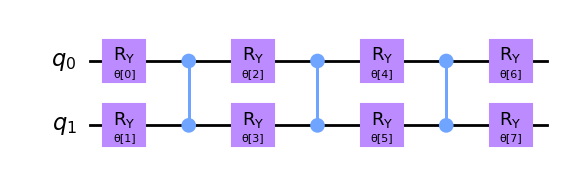

In [3]:
backend_name = "ibmq_qasm_simulator"

backend = service.backend(backend_name)
transpiled = transpile(ansatz, backend=backend)
transpiled.draw("mpl")

{   'aux_operators_evaluated': None,
    'cost_function_evals': 40,
    'eigenvalue': -1.2615875,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001931A6AC250>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 0.5530708898345623,
                              ParameterVectorElement(θ[5]): 0.013755951569895022,
                              ParameterVectorElement(θ[2]): 1.494585474087278,
                              ParameterVectorElement(θ[3]): -0.9375923166697064,
                              ParameterVectorElement(θ[4]): 1.5900727809076567,
                              ParameterVectorElement(θ[7]): 0.3197999698140625,
                              ParameterVectorElement(θ[6]): -0.3893182944294097,
                              ParameterVectorElement(θ[1]): -0.5542053920194107},
    'optimal_point': array([ 0.55307089, -0.55420539,  1.49458547, -0.93759232,  1.59007278,
        0.01375595, -0.38931829,  0.31979997]),
    'optima

Text(0.5, 1.0, "Convergence on IBM's cloud ibmq_qasm_simulator")

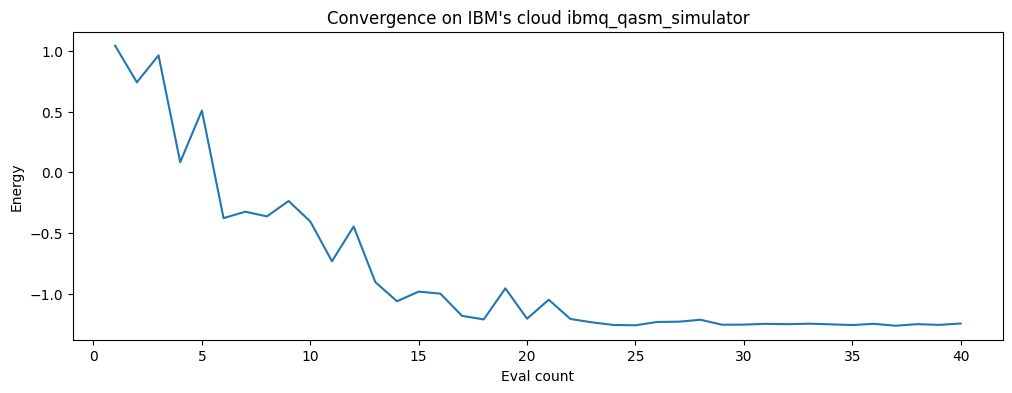

In [4]:
counts = []
values = []

with Session(service, backend=backend_name) as session:
    estimator = Estimator() # no need to pass the session explicitly
    vqe = VQE(estimator, ansatz, optimizer, initial_point=init_pt, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(H_op(0.6, 0.4, 1.25))

print(result)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title(f"Convergence on IBM's cloud {backend_name}")

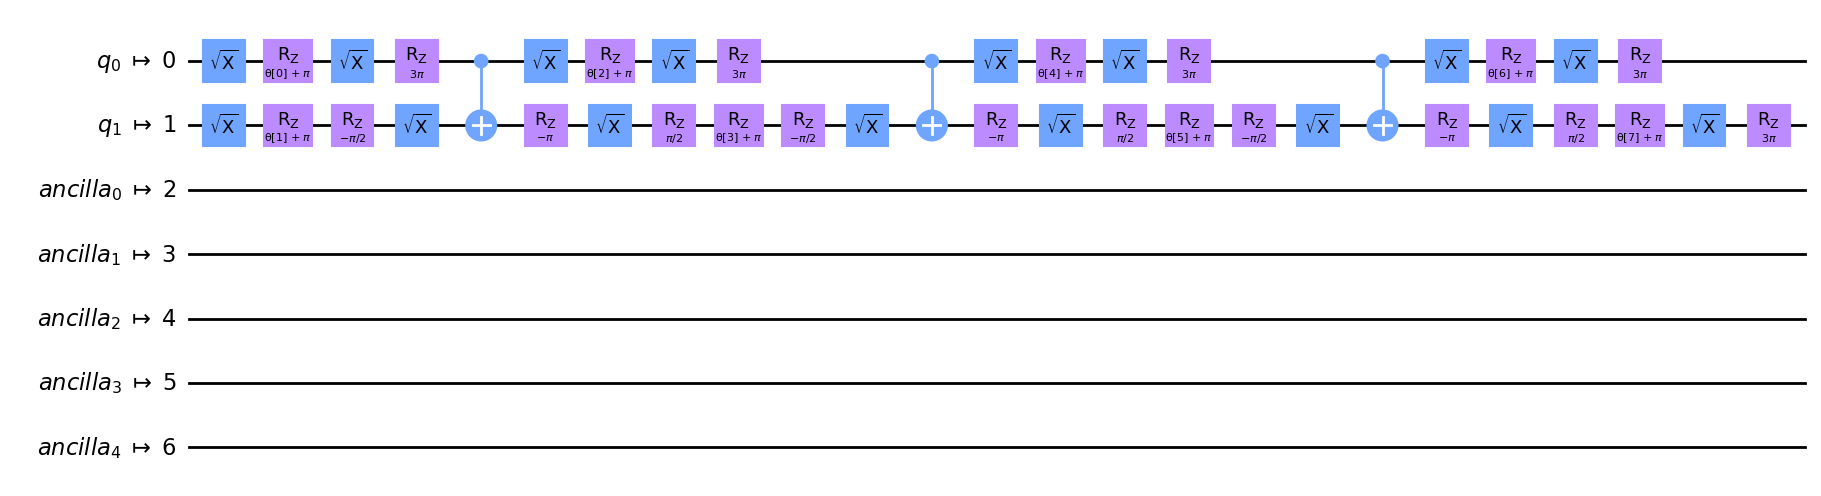

In [5]:
backend_name = "ibm_perth"

backend = service.backend(backend_name)
transpiled = transpile(ansatz, backend=backend)
transpiled.draw("mpl")

{   'aux_operators_evaluated': None,
    'cost_function_evals': 40,
    'eigenvalue': -1.150688886704725,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001931D8EEF80>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 0.9429219778493326,
                              ParameterVectorElement(θ[5]): -0.389832288228827,
                              ParameterVectorElement(θ[2]): 0.7465213513702276,
                              ParameterVectorElement(θ[3]): -0.5911180199901579,
                              ParameterVectorElement(θ[4]): 0.8618668839908236,
                              ParameterVectorElement(θ[7]): 0.3190307240407673,
                              ParameterVectorElement(θ[6]): -0.11743897168793645,
                              ParameterVectorElement(θ[1]): -0.9196818502868155},
    'optimal_point': array([ 0.94292198, -0.91968185,  0.74652135, -0.59111802,  0.86186688,
       -0.38983229, -0.11743897,  0.31903072]),
   

Text(0.5, 1.0, "Convergence on IBM's real ibm_perth")

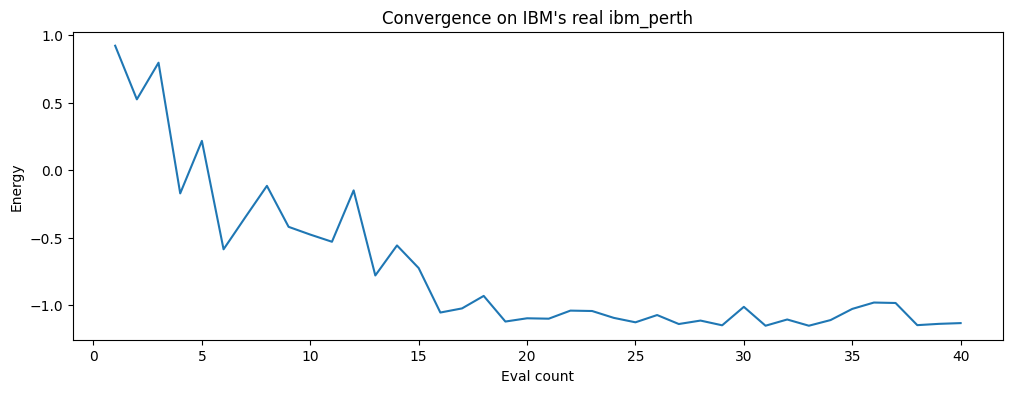

In [8]:
counts = []
values = []

with Session(service, backend=backend_name) as session:
    estimator = Estimator() # no need to pass the session explicitly
    vqe = VQE(estimator, ansatz, optimizer, initial_point=init_pt, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(H_op(0.6, 0.4, 1.25))

print(result)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title(f"Convergence on IBM's real {backend_name}")

The local and IBM simulators give -1.26, the real device gives -1.15, quite the significant difference here.